# Lab: RNNs for Sentiment Analysis


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook we will deploy RNNs to perform sentiment analysis in a real dataset of finantial news. The required preprocesing using standard NLP libraries will be given to you (you have a course on NLP in the second term to learn this part) and your goal will be to define the RNN model, train it and validate the results.


We will use the [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip), which contains  near 5000 sentences from finantial news:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Lets load the database and preprocess it using [SpaCy](https://spacy.io/). This part is all given to you, so no need to worry much.




In [108]:
# To use it in colab, update spacy
!pip install --upgrade spacy

In [109]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 21.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [110]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In lines, we have a list of sentences and an associted label, separated by the character `@`

In [113]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [114]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [115]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


Lets plot the histogram of the labels ...

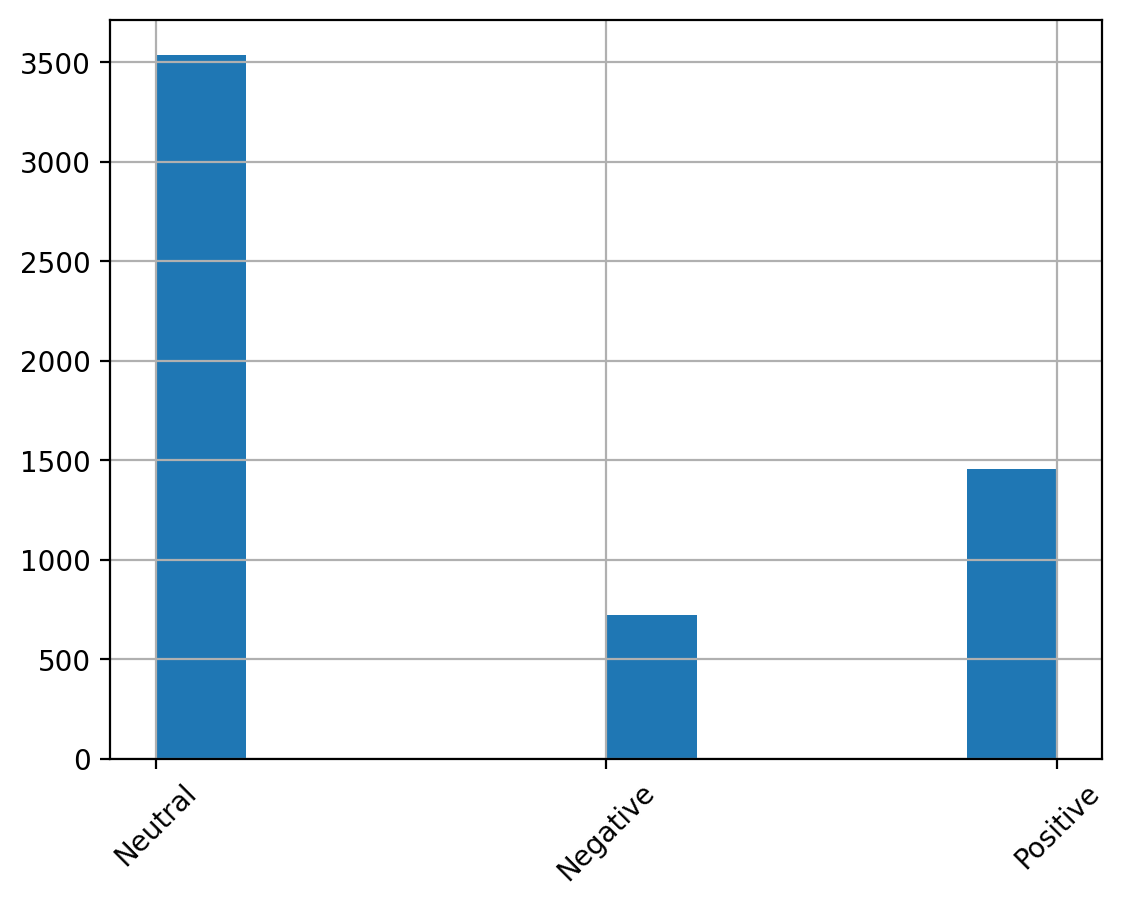

In [116]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [117]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`.

In [118]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]



Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

In [119]:
print(f'The first original sentence is: {phrases[0]}\n')

print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, Gran, company, plans, production, Russia, company, growing]. The length of the document is 8 tokens


We can access to the word embedding of each token using the attribute `.vector`:

In [120]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-8.6201e-01  2.7651e-01 -1.1209e-01  2.9973e-01 -3.2215e-01  1.6662e-01
  3.2387e-01 -2.6418e-01 -9.4269e-02  2.6968e+00 -7.7937e-01 -2.2293e-01
  1.3259e-01 -6.0331e-02 -5.6518e-01 -1.2697e-01 -9.6146e-04  9.5577e-01
 -1.5316e-01 -2.0736e-01  5.1995e-01  2.4404e-01  4.2409e-01 -3.2843e-01
  4.6414e-02  7.0281e-01 -5.6748e-02 -3.1359e-02  5.4413e-04 -2.9599e-01
 -1.2435e-01  2.9698e-02  2.0202e-02  4.3861e-01 -3.5973e-01  2.7488e-01
 -2.0768e-01  2.4601e-01 -9.2236e-02 -1.7892e-01  1.0122e-01 -2.2294e-02
  3.3674e-01 -2.5970e-01  1.0073e-02 -1.5973e-01  2.2097e-02  1.1015e-01
  1.6586e-01 -3.8621e-01 -5.5923e-01 -1.8715e-02 -1.0099e-01 -1.2273e-01
 -8.5288e-02 -6.0562e-02 -3.4501e-01  2.3143e-01  7.2903e-02 -1.3168e-01
  1.7436e-01 -7.8168e-02  5.2544e-02  7.1861e-01  2.0201e-01 -2.6284e-02
  1.2912e-01 -9.9609e-02 -2.0977e-02  8.3424e-01  2.4343e-01 -7.6616e-02
  7.5797e-01  1.1665e-01  6.8503e-01 -2.3969e-01 -1.1874e-01 -2.6

You can check that the word embedding dimension is 300 ...

In [121]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



In [122]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [123]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

Recall that for each document, the sequence of word embeddings is obtained using the `.vector` attribute per token ...

### RNN classification

Our goal is to implement an LSTM that takes as input the sequence of word embeddings and predicts the binary label. In the list `lengths` we have the length per document (before adding the junk tokens). The LSTM prediction **must be done using the LSTM state after processing the last real token**. That means we ignore the LSTM states after we start processing the junk tokens.


A few comments:

- The LSTM is trained using mini-batches. So the input is a tensor of dimension (batch_size, seq_length, max_l). You have to generate this tensor using the lists implemented before (`docs_train`, `docs_val`, `docs_test`).
- You don't care about the LSTM initializaiton. Use the default one.
- The LSTM provides the list of states upon processing the sequences of max_l word embeddings. For each sentence, you have to predict the label using the appropiate state (the one after processing the last real word). My advise is that you store in a list the decision states for each data in the minibatch and then concatenate them in a tensor using `torch.stack`.
- We will use a single MLP layer to perform the prediction. Between the LSTM and the MLP, we include a dropout layer.
- The network will take some time to train, so my advise is to save the network parameters after each epoch (in a separate file), so early stopping can be implemented without re-training.
- Validate the dimension of the LSTM state.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />




In [124]:
from torch import nn
from torch import optim
import torch

>**Exercise 1:** Complete the following code to construct the RNN classifier

In [125]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.n_layers = n_layers

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        # LogSoftmax layer
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Dropout layer
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        '''
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify
        '''

        batch_size = x.size(0)
        seq_length = x.size(1)

        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ = self.rnn(x)

        # Now it comes the tricky part. You have to stack in a (batch_size, hidden_dim) tensor, the right state
        # for each sequence. Namely, the state after processing the last real token (not the junk # ones)
        # The function torch.stack() can be handy

        aux = torch.stack([r_out[d, lengths[d]-1, :] for d in range(batch_size)]).reshape([-1, self.hidden_dim])

        # We classify using such tensor (don't forget the dropout!)
        output = self.logsoftmax(self.fc1(self.dropout(aux)))

        return output


Let's first illustrate how we can get the output of the (untrained) RNN network given our texts. For example, let's get the RNN output for the first three training texts. The first step is to get the **sequences of word embeddings** of each of them...

In [126]:
idx = [0,1,2] #changing these parameters (python starts counting on 0)

#[w.vector for w in docs_train[d]] generates the list of word vectors for the d-th document
x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])

In [127]:
d=1

np.array([docs_train[d][w].vector for w in range(len_train[d])]).shape

(15, 300)

In [128]:
aux = torch.Tensor([np.mean([docs_train[d][w].vector for w in range(len_train[d])],0) for d in idx])

The shape of `x_input` should be (3,max_l,300)

In [129]:
x_input.shape

torch.Size([3, 35, 300])

Let's instantiate the RNN class

In [130]:
my_RNN = RNN(300,2,20,1)

> **Exercise 2:** evaluate the RNN otuput for `x_input` and check that the ouput dimensions make sense

In [131]:
x_batch = x_input  # x es tu tensor de entradas con las secuencias de texto
lengths = [lengths[d] for d in idx]  # Las longitudes de las secuencias en el lote

# Pasar las secuencias y las longitudes al modelo
o = my_RNN.forward(x_batch, lengths)

In [132]:
print(o)

tensor([[-0.3331, -1.2611],
        [-0.5753, -0.8268],
        [-0.5378, -0.8771]], grad_fn=<LogSoftmaxBackward0>)


In [133]:
o.shape

torch.Size([3, 2])

> **Exercise 3:** Complete the following class, which inherits the previous one and it adds a training loop, an evaluation method, and functionalities to save the model every few epochs

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class RNN_with_train(RNN):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0, batch_size=50, lr=0.0005, saved_files='./saved_models/RNN_sentiment_analysis'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob)

        self.lr = lr  # Learning Rate
        self.optim = optim.Adam(self.parameters(), lr=self.lr)  # Optimizer
        self.criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss
        self.loss_during_training = []  # Stores training loss
        self.valid_loss_during_training = []  # Stores validation loss
        self.batch_size = batch_size  # Batch size for training
        self.saved_files = saved_files  # Directory to save the model

    def predict_proba(self, docs, lengths, Y=None):
        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():
            # Prepare input for the model: word embeddings for each document
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            # Get log probabilities for the input documents
            logprobs = self.forward(x_input, lengths).detach().numpy()

            # Calculate accuracy if labels are provided
            if len(Y) > 0:
                accuracy = np.sum(np.argmax(logprobs, 1) == Y) / np.shape(Y)[0]

        return logprobs, accuracy

    def fit(self, docs_train, docs_val, Y, Yval, len_train, len_val, epochs=100, print_every=5):
        '''
        Método de entrenamiento.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''
        self.print_every = print_every
        self.epochs = epochs

        # Optimization Loop
        self.num_train = len(docs_train)  # Number of training points
        self.num_batchs = np.floor(self.num_train / self.batch_size)  # Number of training batches
        self.num_val = len(docs_val)  # Number of validation points
        self.num_batchs_val = np.floor(self.num_val / self.batch_size)  # Number of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor)  # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)  # Validation labels

        for e in range(int(self.epochs)):

            self.train()  # Set model to training mode (activates dropout)

            # Random data permutation for training
            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch
                idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d] > 0]

                # Prepare the input: sequences of word embeddings
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # Compute the classifier output for each batch
                out = self.forward(x_input, [len_train[d] for d in idx_batch])

                # Calculate the loss
                loss = self.criterion(out, labels[idx_batch])

                running_loss += loss.item()

                # Backpropagation
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # Update the model parameters
                self.optim.step()

            # Store the average training loss
            self.loss_during_training.append(running_loss / self.num_batchs)

            # Save the model after each epoch
            torch.save(self.state_dict(), self.saved_files + '_epoch_' + str(e) + '.pth')

            # Validation
            with torch.no_grad():
                # Set model to evaluation mode (disables dropout)
                self.eval()

                running_loss = 0.
                idx = np.random.permutation(self.num_val)

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d] > 0]

                    # Prepare the input for the validation batch
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    # Compute the classifier output for each validation batch
                    out = self.forward(x_input, [len_val[d] for d in idx_batch])

                    # Calculate the loss
                    loss = self.criterion(out, labelsval[idx_batch])

                    running_loss += loss.item()

                # Store the average validation loss
                self.valid_loss_during_training.append(running_loss / self.num_batchs_val)

            # Print the training and validation loss every few epochs
            if e % self.print_every == 0:
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")


> **Exercise 4:** Instantiate and train the class using a hidden state of 20 dimensions and dropout probability equal to 0.3. Train for 40 epochs (can take a while)

In [135]:
# Define the necessary variables
input_size = 300
output_size = 2
hidden_dim = 20
n_layers = 1
prob = 0.3
batch_size = 50
lr = 0.0005
saved_files = './RNN_sentiment_analysis'

# Instantiate and train the class
my_RNN = RNN_with_train(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim,
                        n_layers=n_layers, prob=prob, batch_size=batch_size, lr=lr, saved_files=saved_files)

# Call the train method to train the model
my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)

Training loss after 0 epochs: 0.49763909635478504. Validation loss: 0.37480014231469894
Training loss after 1 epochs: 0.3696638162005438. Validation loss: 0.31339436769485474
Training loss after 2 epochs: 0.33946136722009473. Validation loss: 0.2972502269678646
Training loss after 3 epochs: 0.32141829026888497. Validation loss: 0.28519941452476716
Training loss after 4 epochs: 0.30676931489820347. Validation loss: 0.2762544047501352
Training loss after 5 epochs: 0.2936348749758446. Validation loss: 0.2608674011296696
Training loss after 6 epochs: 0.2717538337184958. Validation loss: 0.2585734236571524
Training loss after 7 epochs: 0.24989566013012846. Validation loss: 0.24454817589786318
Training loss after 8 epochs: 0.22613151039775103. Validation loss: 0.2373266335990694
Training loss after 9 epochs: 0.2027144259581827. Validation loss: 0.2355786988304721
Training loss after 10 epochs: 0.18950923001521255. Validation loss: 0.22280719131231308
Training loss after 11 epochs: 0.17134880

> **Exercise 5:** Plot both validation and training loss. Recover the model parameters for the epoch that minimized the validation loss. To do so, note that at every epoch the model parameters are save in a certain file named  `RNN_sentiment_analysis_epoch_X.pth` (unless you changed the default value), where `X` is the epoch. The function to re-state the parameters of the network are  `state_dict = my_RNN.load_state_dict(torch.load('RNN_sentiment_analysis_epoch_X.pth'))
`

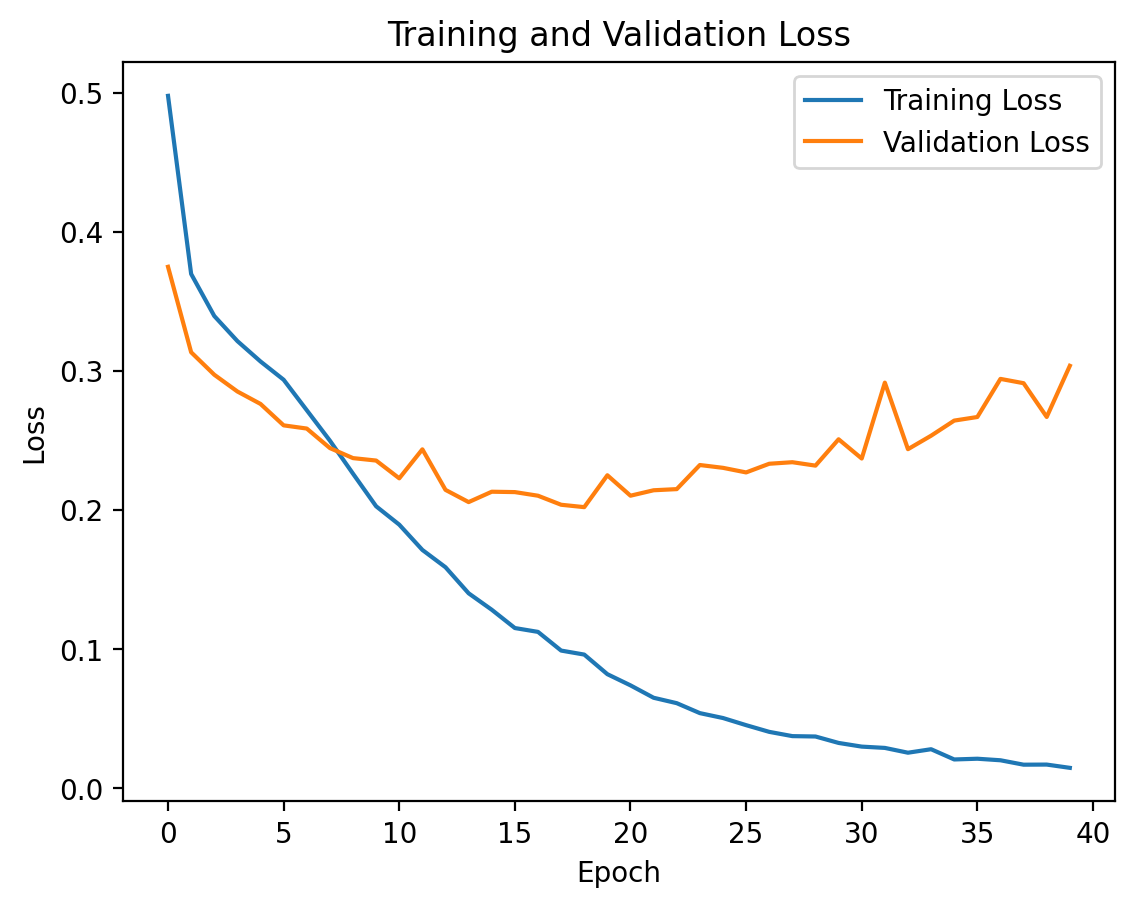

Minimum validation loss achieved at epoch 18


In [152]:
# Plot training and validation loss
plt.plot(my_RNN.loss_during_training, label='Training Loss')
plt.plot(my_RNN.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(my_RNN.valid_loss_during_training)

# Load the model parameters from the epoch with minimum validation loss
state_dict = my_RNN.load_state_dict(torch.load(f'./RNN_sentiment_analysis_epoch_{min_val_loss_epoch}.pth'))

print(f"Minimum validation loss achieved at epoch {min_val_loss_epoch}")


there is a little bit of overfitting

In [145]:
# Recovering the best validation parameters

# Recuperar los índices de las épocas ordenadas por la menor pérdida de validación
idx_min = np.argsort(my_RNN.valid_loss_during_training)

# Cargar el modelo con los mejores parámetros (el de la mínima pérdida de validación)
my_RNN.load_state_dict(torch.load(my_RNN.saved_files + '_epoch_' + str(idx_min[0]) + '.pth'))

<All keys matched successfully>

we also save it in a specific folder:


In [146]:
# Recovering the best validation parameters
idx_min = np.argsort(my_RNN.valid_loss_during_training)
best_epoch = idx_min[0]

# Load the model parameters corresponding to the epoch with the lowest validation loss
state_dict = my_RNN.load_state_dict(torch.load(f'/content/RNN_sentiment_analysis_epoch_{best_epoch}.pth'))

> **Exercise 6:** Using the method `predict_proba`, compute the accuracy and class probabilities for the data in the test set. Note that the method returns log-probabilities that you have to exponentiate.

In [147]:
# Ensure that len_test only contains positive values
valid_idx = [i for i, length in enumerate(len_test) if length > 0]

# Use list comprehension to filter the valid sequences, lengths, and labels
docs_test = [docs_test[i] for i in valid_idx]
len_test = [len_test[i] for i in valid_idx]
y_test = [y_test[i] for i in valid_idx]


In [148]:
logprobs, acc = my_RNN.predict_proba(docs_test, len_test, Y=y_test)

# Convert log-probabilities to probabilities
probs = np.exp(logprobs)

# Print the accuracy of the model on the test set
print(f"The test accuracy is {acc}")

The test accuracy is 0.9343832020997376


*class Probabilities:*

In [149]:
# Convert y_test to a numpy array first to properly compute baseline acc
y_test_array = np.array(y_test)

# Also check the class distribution
print(f"Number of class 0 (Neutral/Positive): {np.sum(y_test_array == 0)}")
print(f"Number of class 1 (Negative): {np.sum(y_test_array == 1)}")

Number of class 0 (Neutral/Positive): 1003
Number of class 1 (Negative): 140


In [150]:
# Find the epoch with the minimum validation loss
best_epoch = np.argmin(my_RNN.valid_loss_during_training)
min_val_loss = np.min(my_RNN.valid_loss_during_training)

print(f"Best model found at epoch {best_epoch} with validation loss: {min_val_loss:.4f}")

# Load the best model
best_model_path = f'./RNN_sentiment_analysis_epoch_{best_epoch}.pth'
state_dict = my_RNN.load_state_dict(torch.load(best_model_path))

# Test the loaded model on the test set
logprobs, test_accuracy = my_RNN.predict_proba(docs_test, len_test, Y=y_test)
print(f"Test accuracy with best model: {test_accuracy:.4f}")

# baseline correctly
baseline_accuracy = max(np.sum(y_test_array == 0), np.sum(y_test_array == 1)) / len(y_test_array)
print(f"Baseline accuracy (majority class): {baseline_accuracy:.4f}")

# Let's also visualize some predictions
num_examples = 5
random_indices = np.random.choice(len(docs_test), num_examples, replace=False)

print("\nExample predictions:")
print("-" * 60)
for idx in random_indices:
    # Get the original text
    original_tokens = [token.text for token in norm_docs[idx_test[idx]][:len_test[idx]]]
    original_text = " ".join(original_tokens)

    # Get the predicted label and true label
    pred_label = np.argmax(logprobs[idx])
    true_label = y_test[idx]

    # Get prediction confidence
    confidence = np.exp(logprobs[idx][pred_label])

    print(f"Text: {original_text}")
    print(f"True label: {'Negative' if true_label == 1 else 'Neutral/Positive'}")
    print(f"Predicted label: {'Negative' if pred_label == 1 else 'Neutral/Positive'} (confidence: {confidence:.2f})")
    print("-" * 60)


Best model found at epoch 18 with validation loss: 0.2021
Test accuracy with best model: 0.9344
Baseline accuracy (majority class): 0.8775

Example predictions:
------------------------------------------------------------
Text: mall financed parity basis Pearl Plaza LLC joint venture company established Chinese investor Shanghai Industrial Investment Holdings Co Ltd SRV Group
True label: Neutral/Positive
Predicted label: Neutral/Positive (confidence: 1.00)
------------------------------------------------------------
Text: Simmons Elected Chairman PORTSMOUTH A. Simmons CEO Service Credit Union elected chairman Defense Credit Union Council 2007 2008 term
True label: Neutral/Positive
Predicted label: Neutral/Positive (confidence: 1.00)
------------------------------------------------------------
Text: example net sales increased 5.9 quarter EBITDA increased negative EUR 0.2 mn quarter 2009
True label: Neutral/Positive
Predicted label: Neutral/Positive (confidence: 0.98)
------------------

The following code plots the ROC curve of the classifiers, and it computes the area under the curve:

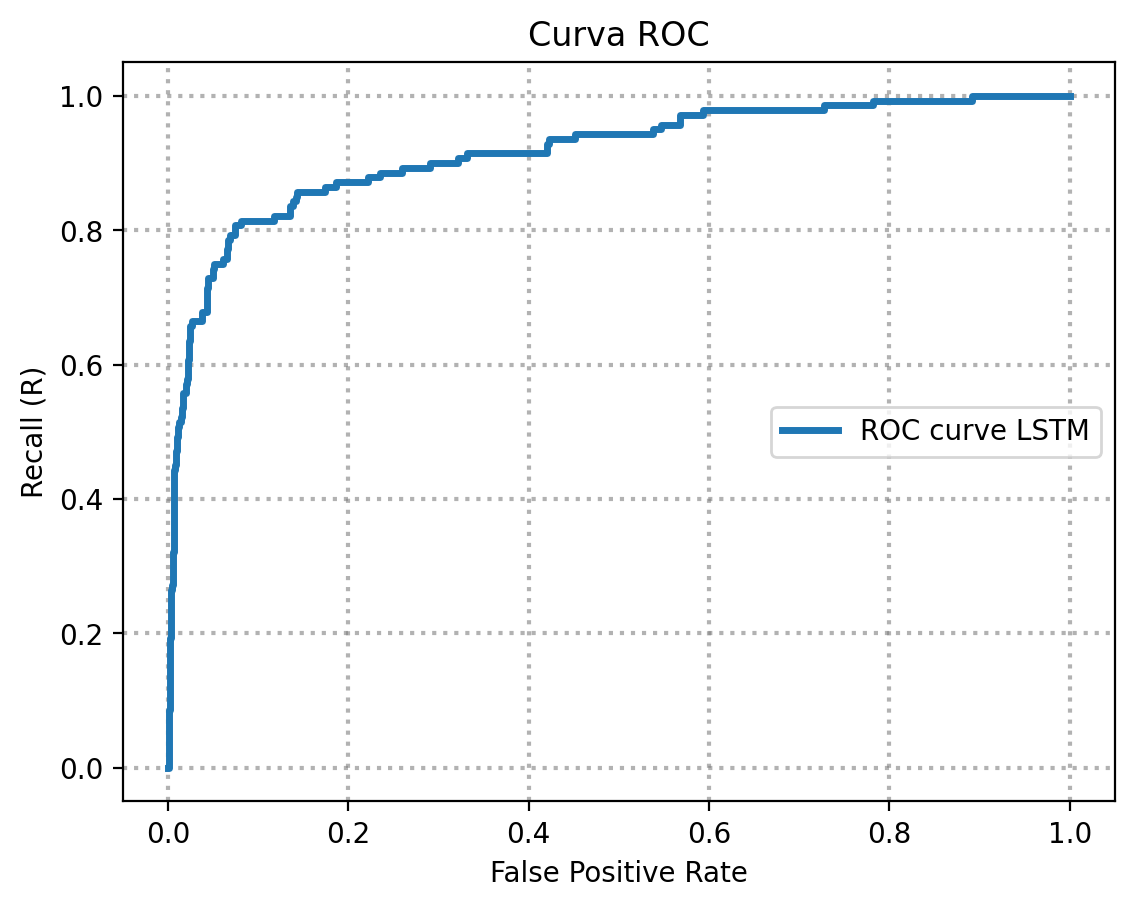

AUC ROC for LSTM is 0.9165717134311352


In [151]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(axis='both', which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

If you do not implement the optimal part, just know that the proposed MLP solution AUC is typically less than 0.9